<center><H1>EE 679: Computing Assignment 1</H1>
<H2> Name: Vinit Awale</H2>
<H2> Roll No: 18D070067 </H2>
<H2> Date: 2/9/2021</H2>
</center>

## <b><i> Question 1:</i></b>
 Given the following specification for a single-formant resonator, obtain the transfer function of the filter H(z) from the relation between resonance frequency / bandwidth, and the pole angle / radius.  Plot filter magnitude response (dB magnitude versus frequency) and impulse response.
 
  
<b> F1 (formant) = 900 Hz   </b>     
<b> B1(bandwidth) = 200 Hz    </b>     
<b> Fs (sampling freq) = 16 kHz   </b>    

## <b> Solution: </b>
We can calculate the transfer function using the following equation:
$$ 
H(z) = \frac{1}{1-2rcos \theta z^{-1} + r^2 z^{-2}}
$$

Where $r$ is the magnitude of the pole and $theta$ is the angle of the pole.
$$
    r = e^{-\pi B T} \\
    \theta = 2\pi FT
$$
where, T is the sampling period and F is the frequency of the formant.

Further, to get the transfer function as a function of the frequency, we can substitute z as:
$$
    z = e^{j\omega T} = e^{\frac{j 2\pi f}{Fs} }
$$ 
$$
    \implies H(f) = \left.\frac{1}{1-2rcos \theta z^{-1} + r^2 z^{-2}}\right|_{z = e^{\frac{j 2\pi f}{Fs} } }
$$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import IPython

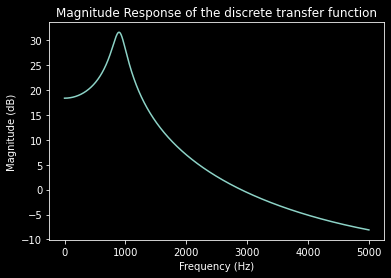

In [2]:

# Input Parameters

F1 = 900
B1 = 200
Fs = 16000

freq_range = np.arange(0,5000,1)

# Function to calculate the transfer function magnitude from poles parameters 
def H_discrete_transfer_mag(F1, B1, Fs):
    """ Function to get the magnitude of thediscrete transfer function from Formant freq and bandwidth
        
    Args:
        F1 (int): Formant frequency
        B1 (int): Formant bandwidth
        Fs (int): Sampling frequency

    Returns:
        [ndarray]: Magnitude of the discrete transfer function
    """   
    T = 1/Fs                                # Sampling period
    H_discrete = []                         # Empty list to store the discrete transfer function
    r1 = np.exp(-np.pi*B1*T)                # Magnitude of the pole corresponding to the formant 1
    theta1 = 2*np.pi*F1*T                   # Angle of the pole corresponding to the formant 1
    freq_range = np.arange(0,5000,1)        # define the range of frequency values
    
    for f in freq_range:
        z = np.exp(2j*np.pi*f/Fs)           # complex exponential in discrete domain
        H = 1/(1-2*r1*np.cos(theta1)*z**-1 + r1**2*z**-2)  # discrete transfer function calculation
        H_discrete.append(np.abs(H))

    return H_discrete   

H = H_discrete_transfer_mag(F1, B1, Fs)

plt.plot(freq_range, 20* np.log10(H))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Magnitude Response of the discrete transfer function')
plt.show()

### Calculation of the Impulse Response

To calculate the Impulse Response we construct the difference equation from the transfer function.
$$
    H(z) = \frac{1}{1-2rcos \theta z^{-1} + r^2 z^{-2}}
$$
Comparing H(z) with standard form of transfer function
$$
    H(z) = \frac{b_0}{a_0+ a_1 z^{-1} + a_2 z^{-2}}
$$
we get:
$$
    a_0 = 1 \\
    a_1 = -2rcos \theta \\
    a_2 = r^2  \\
    b_0 = 1    
$$
Hence, we can form the difference equation from the transfer function as follows:
$$
    a_0 y[n] + a_1 y[n-1] + a_2 y[n-2] = b_0 x[n] \\
    \implies a_0 y[n] = b_0 x[n] - a_1 y[n-1] - a_2 y[n-2]
$$

Subsituting the values of $a_0$, $a_1$, $a_2$ and $b_0$ in the above equation we get:
$$
    y[n] = x[n] + 2rcos \theta x[n-1] - r^2 x[n-2]
$$


In [3]:
# Implement the given filter as a difference equation

def filter(x, F1, B1):
    """ Function to get the output signal when input signal x is passed through filter with Formant Freq F1 and 
    Formant Bandwidth B1

    Args:
        x (ndarray): Input signal
        F1 (int): Formant Frequency
        B1 (int): Formant Bandwidth

    Returns:
        [ndarray]: Output signal
    """
    T = 1/Fs                                # Sampling period
    r1 = np.exp(-np.pi*B1*T)                # Magnitude of the pole corresponding to the formant 1
    theta1 = 2*np.pi*F1*T                   # Angle of the pole corresponding to the formant 1
    y = np.zeros(x.size)                    # Initialize output array

    # Assuming initial reset we get the first two terms of the output as 
    y[0] = x[0]
    y[1] = x[1] + 2*r1*np.cos(theta1)*y[0]

    # The rest of the output is calculated using the difference equation
    for i in range(2, x.size):
        y[i] = x[i] + 2*r1*np.cos(theta1)*y[i-1] - r1**2*y[i-2]

    return y

Now, to calculate the impulse response for the filter with given formant, we pass an impulse through the filter and observe the output.

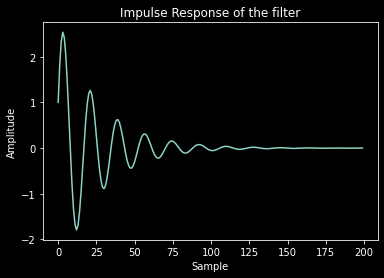

In [4]:
impulse = np.zeros(200)         
impulse[0] = 1                          # Impulse signal

impulse_response = filter(impulse,F1,B1)      # Impulse response of the filter

plt.plot(impulse_response)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Impulse Response of the filter')
plt.show()

## <b><i> Question 2:</i></b>
Excite the above resonator (“filter”) with a periodic source excitation of F0 = 140 Hz. You can approximate the source signal by a narrow-triangular pulse train. Compute the output of the source-filter system over the duration of 0.5 second using the difference equation implementation of the LTI system.  Plot the time domain waveform over a few pitch periods so that you can observe waveform characteristics.  Play out the 0.5 sec duration sound and comment on the sound quality.    

## <b> Solution: </b>
First we make the required periodic source excitation. For this we assume triangular pulse train with a period of 0.5 sec with triangular pulse of frequency 140 Hz.

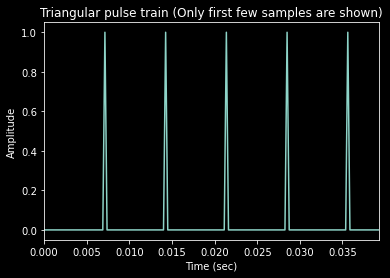

In [5]:
duration = 0.5                                             # Duration of the signal    

F0 = 140                                                   # Impulse frequency
time = np.arange(0, duration, 1/Fs)                        # Time vector
# Function to generate the triangular pulse train with given impulse frequency F0
def triangular_pulse_train_gen(F0, duration, Fs):
    triangular_pulse_train = np.zeros(time.size)           # Empty vector to store the output
    # Generating the triangular pulse train
    for i in range(time.size):
        if i%(Fs//F0) == 0 and i != 0:
            triangular_pulse_train[i] = 1               
            triangular_pulse_train[i+1] = 0.75      
            triangular_pulse_train[i-1] = 0.75      
            triangular_pulse_train[i+2] = 0.5
            triangular_pulse_train[i-2] = 0.5
            triangular_pulse_train[i+3] = 0.25
            triangular_pulse_train[i-3] = 0.25

    return triangular_pulse_train


triangular_pulse_train = triangular_pulse_train_gen(F0, duration, Fs)  # Generating the triangular pulse train for given parameters
    
plt.plot(time, triangular_pulse_train)  # Plot the triangular pulse train
plt.xlim(0,5.5/F0)       # Limit the x-axis to show 5 impulse periods
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Triangular pulse train (Only first few samples are shown)')
plt.show()

Now, we pass this triangular_pulse_train through the filter and observe the output.

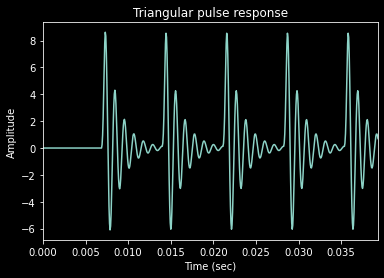

In [6]:
triangular_pulse_response = filter(triangular_pulse_train,F1,B1)  # Pass the triangular pulse train through the filter

plt.plot(time, triangular_pulse_response)                   # Plot the output of the filter
plt.xlim(0,5.5/F0)                           # Limit the x-axis to show 5 impulse periods
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Triangular pulse response')
plt.show()

Now, we play this triangular_pulse_response to observe the sound.

In [7]:
# Write the input sound to input.wav
input_sound = np.int16(triangular_pulse_train/np.max(np.abs(triangular_pulse_train))*32767)
write('input.wav', Fs, input_sound)

# Write the output sound to output.wav
output_sound = np.int16(triangular_pulse_response/np.max(np.abs(triangular_pulse_response))*32767)
write("output.wav",Fs,output_sound)

### Input Sound

In [8]:
IPython.display.Audio("input.wav")

### Output Sound

In [9]:
IPython.display.Audio("output.wav")

### Observation:
#### The output sound heard was rough in quality and had a low pitch.

## <b><i> Question 3:</i></b>
Vary the parameters as indicated below; plot and comment on the differences in waveform and in sound quality for the different parameter combinations.
- <b>F0 = 120 Hz, F1 = 300 Hz, B1 = 100 Hz </b>   
- <b>F0 = 120 Hz, F1= 1200 Hz, B1 = 200 Hz  </b>  
- <b>F0 = 180 Hz, F1 = 300 Hz, B1 = 100 Hz </b>   

## <b> Solution: </b>
### Generate triangular pulse train with period of 0.5 sec and frequencies mentioned above.

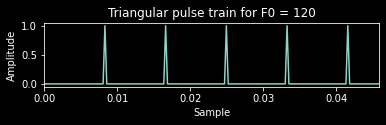

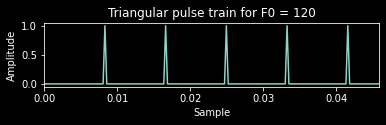

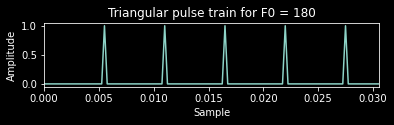

In [10]:
F0s = np.array([120,120,180])               # Array of F0 values

# Generate triangular pulse train with given impulse frequencies F0s
triangular_pulse_trains = [triangular_pulse_train_gen(F0s[i], duration, Fs) for i in range(len(F0s))] 

# Plot the triangular pulse trains for the three cases 
for i in range(len(F0s)):
    plt.subplot(len(F0s),1,i+1)
    plt.plot(time, triangular_pulse_trains[i])
    plt.xlim(0,5.5/F0s[i])
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title('Triangular pulse train for F0 = ' + str(F0s[i]))
    plt.show()

### Now, lets have a look at the Magnitude of the transfer function for the given three cases

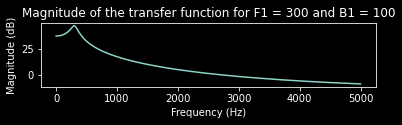

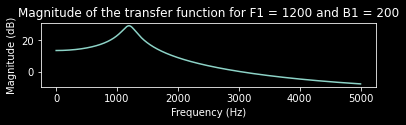

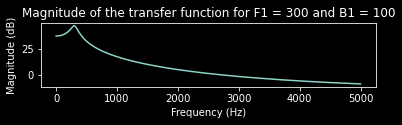

In [11]:
F1s = np.array([300,1200,300])               # Array of F1 values
B1s = np.array([100,200,100])                # Array of B1 values

H_mags = [H_discrete_transfer_mag(F1s[i], B1s[i], Fs) for i in range(len(F1s))]  # Array of H magnitudes

# Plot the Magnitude of the transfer function for the three cases
for i in range(len(F1s)):
    plt.subplot(len(F1s),1,i+1)
    plt.plot(freq_range, 20*np.log10(H_mags[i]))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('Magnitude of the transfer function for F1 = ' + str(F1s[i]) + ' and B1 = ' + str(B1s[i]))
    plt.show()

### Now let us see the output of the filter for the given three cases.

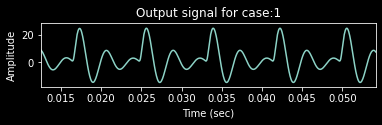

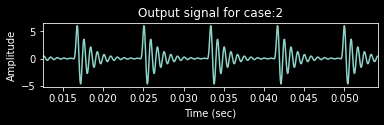

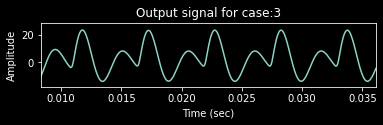

In [12]:
outputs = [filter(triangular_pulse_trains[i],F1s[i],B1s[i]) for i in range(len(F1s))]  # Array of output signals

# Plot the output signals for the three cases
for i in range(len(F1s)):
    plt.subplot(len(F1s),1,i+1)
    plt.plot(time, outputs[i])
    plt.xlim(1.5/F0s[i],6.5/F0s[i])
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude')
    plt.title('Output signal for case:'+str(i+1))
    plt.show()

### Now we save the input and output of the filter for the given three cases.

In [13]:
# Write the input sound to input.wav
input_sounds = [np.int16(triangular_pulse_trains[i])*32767 for i in range(len(F1s))] # No need to divide by max since it is 1
for i in range(len(F1s)):
    write('input_'+str(i+1)+'.wav', Fs, input_sounds[i])

# Write the output sound to output.wav
output_sounds = [np.int16(outputs[i]/np.max(np.abs([outputs[i]]))*32767) for i in range(len(F1s))] 
for i in range(len(F1s)):
    write("output_"+str(i+1)+".wav",Fs,output_sounds[i])

### Comparing Sound Quality 

### Input 1

In [14]:
IPython.display.Audio("input_1.wav")

### Output 1

In [15]:
IPython.display.Audio("output_1.wav")

### Input 2

In [16]:
IPython.display.Audio("input_2.wav")

### Output 2

In [17]:
IPython.display.Audio("output_2.wav")

### Input 3

In [18]:
IPython.display.Audio("input_3.wav")

### Output 3

In [19]:
IPython.display.Audio("output_3.wav")

### Observation:
#### The correlation between the bandwidth and the decay rate of the waveform can be directly seen from the three waveforms and their corresponding bandwidth values. In subpart 'b' as the bandwidth increased, the decay rate has increased. This can be thought as a result of allowing more higher frequncies. Because of this there is far lesser interference in subpart 'b' as compared to the other 2 parts. Same is observed consistently with the result of question 2. 

#### The 1st and the 3rd waveforms appear to sound alike whereas the 2nd waveform is totally distinct from the other two. However, the 1st waveform appears to be a little rougher as compared to the 3rd waveform

## <b><i> Question 4:</i></b>
### In place of the simple single-resonance signal, synthesize the following more realistic vowel sounds at two distinct pitches (F0 = 120 Hz, F0 = 220 Hz). Keep the bandwidths constant at 100 Hz for all formants. Duration of sound: 0.5 sec. Comment on the sound quality across the different sounds. Plot a few periods of any 2 examples.
|  Vowel  | F1  | F2  | F3  |
|:-------:|:---:|:---:|:---:|
|   /a/   | 730 |1090 |2440 | 
|   /i/   | 270 |2290 |3010 |
|   /u/   | 300 | 870 |2240 |


### <b> Solution: </b>

For the case when we have three formants, we can use the following transfer function:
$$
    H(z) = \frac{1}{(1-2r_1cos \theta_1 z^{-1} + r_1^2 z^{-2}) (1-2r_2cos \theta_2 z^{-1} + r_2^2 z^{-2}) (1-2r_3cos \theta_3 z^{-1} + r_3^2 z^{-2})}
$$

In [20]:
import sympy as sp 

# Make variables theta_1, r_1, theta_2, r_2, theta_3, r_3
theta_1, r_1, theta_2, r_2, theta_3, r_3 = sp.symbols('theta_1, r_1, theta_2, r_2, theta_3, r_3')                               

z = sp.Symbol('z')                      # Make variable for discrete complex exponential

# Define the transfer function
H = 1/((1-2*r_1*sp.cos(theta_1)*z**-1+r_1**2*z**-2)*(1-2*r_2*sp.cos(theta_2)*z**-1+r_2**2*z**-2)*(1-2*r_3*sp.cos(theta_3)*z**-1+r_3**2*z**-2)) 

H       # Display the transfer function

1/((r_1**2/z**2 - 2*r_1*cos(theta_1)/z + 1)*(r_2**2/z**2 - 2*r_2*cos(theta_2)/z + 1)*(r_3**2/z**2 - 2*r_3*cos(theta_3)/z + 1))

In [21]:
H = H.expand()          # Expand the transfer function
H = H.collect(z**-1)    # Collect terms in the transfer function

H       # Display the expanded transfer function

1/(r_1**2*r_2**2*r_3**2/z**6 + 1 + (-2*r_1*cos(theta_1) - 2*r_2*cos(theta_2) - 2*r_3*cos(theta_3))/z + (r_1**2 + 4*r_1*r_2*cos(theta_1)*cos(theta_2) + 4*r_1*r_3*cos(theta_1)*cos(theta_3) + r_2**2 + 4*r_2*r_3*cos(theta_2)*cos(theta_3) + r_3**2)/z**2 + (-2*r_1**2*r_2*cos(theta_2) - 2*r_1**2*r_3*cos(theta_3) - 2*r_1*r_2**2*cos(theta_1) - 8*r_1*r_2*r_3*cos(theta_1)*cos(theta_2)*cos(theta_3) - 2*r_1*r_3**2*cos(theta_1) - 2*r_2**2*r_3*cos(theta_3) - 2*r_2*r_3**2*cos(theta_2))/z**3 + (r_1**2*r_2**2 + 4*r_1**2*r_2*r_3*cos(theta_2)*cos(theta_3) + r_1**2*r_3**2 + 4*r_1*r_2**2*r_3*cos(theta_1)*cos(theta_3) + 4*r_1*r_2*r_3**2*cos(theta_1)*cos(theta_2) + r_2**2*r_3**2)/z**4 + (-2*r_1**2*r_2**2*r_3*cos(theta_3) - 2*r_1**2*r_2*r_3**2*cos(theta_2) - 2*r_1*r_2**2*r_3**2*cos(theta_1))/z**5)

Now, we have to compare the transfer function with the standard form of transfer function given by:
$$
    H(z) = \frac{b_0}{a_0+ a_1 z^{-1} + a_2 z^{-2} + a_3 z^{-3} + a_4 z^{-4} + a_5 z^{-5} + a_6 z^{-6}}
$$

For finding the coefficients of the above transfer function, we find the denominator of the transfer function and then get the respective coefficients.

In [22]:
denom = 1/H                     # Make denominator of the transfer function
denom = denom.collect(z**-1)    # Collect terms in the denominator

denom      # Display the denominator

r_1**2*r_2**2*r_3**2/z**6 + 1 + (-2*r_1*cos(theta_1) - 2*r_2*cos(theta_2) - 2*r_3*cos(theta_3))/z + (r_1**2 + 4*r_1*r_2*cos(theta_1)*cos(theta_2) + 4*r_1*r_3*cos(theta_1)*cos(theta_3) + r_2**2 + 4*r_2*r_3*cos(theta_2)*cos(theta_3) + r_3**2)/z**2 + (-2*r_1**2*r_2*cos(theta_2) - 2*r_1**2*r_3*cos(theta_3) - 2*r_1*r_2**2*cos(theta_1) - 8*r_1*r_2*r_3*cos(theta_1)*cos(theta_2)*cos(theta_3) - 2*r_1*r_3**2*cos(theta_1) - 2*r_2**2*r_3*cos(theta_3) - 2*r_2*r_3**2*cos(theta_2))/z**3 + (r_1**2*r_2**2 + 4*r_1**2*r_2*r_3*cos(theta_2)*cos(theta_3) + r_1**2*r_3**2 + 4*r_1*r_2**2*r_3*cos(theta_1)*cos(theta_3) + 4*r_1*r_2*r_3**2*cos(theta_1)*cos(theta_2) + r_2**2*r_3**2)/z**4 + (-2*r_1**2*r_2**2*r_3*cos(theta_3) - 2*r_1**2*r_2*r_3**2*cos(theta_2) - 2*r_1*r_2**2*r_3**2*cos(theta_1))/z**5

In [23]:
# Comparing the numerator and denominator of the transfer function to determine the coefficients
b0 = 1
a0 = 1              # By mere inspection of the denominator terms
a1 = denom.coeff(z**-1)         # Coefficient of z^-1
a2 = denom.coeff(z**-2)         # Coefficient of z^-2
a3 = denom.coeff(z**-3)         # Coefficient of z^-3
a4 = denom.coeff(z**-4)         # Coefficient of z^-4
a5 = denom.coeff(z**-5)         # Coefficient of z^-5
a6 = denom.coeff(z**-6)         # Coefficient of z^-6

In [24]:
# Display the coefficients
print('a0 = ' + str(a0)+'\n')
print('a1 = ' + str(a1)+'\n')
print('a2 = ' + str(a2)+'\n')
print('a3 = ' + str(a3)+'\n')
print('a4 = ' + str(a4)+'\n')
print('a5 = ' + str(a5)+'\n')
print('a6 = ' + str(a6)+'\n')

a0 = 1

a1 = -2*r_1*cos(theta_1) - 2*r_2*cos(theta_2) - 2*r_3*cos(theta_3)

a2 = r_1**2 + 4*r_1*r_2*cos(theta_1)*cos(theta_2) + 4*r_1*r_3*cos(theta_1)*cos(theta_3) + r_2**2 + 4*r_2*r_3*cos(theta_2)*cos(theta_3) + r_3**2

a3 = -2*r_1**2*r_2*cos(theta_2) - 2*r_1**2*r_3*cos(theta_3) - 2*r_1*r_2**2*cos(theta_1) - 8*r_1*r_2*r_3*cos(theta_1)*cos(theta_2)*cos(theta_3) - 2*r_1*r_3**2*cos(theta_1) - 2*r_2**2*r_3*cos(theta_3) - 2*r_2*r_3**2*cos(theta_2)

a4 = r_1**2*r_2**2 + 4*r_1**2*r_2*r_3*cos(theta_2)*cos(theta_3) + r_1**2*r_3**2 + 4*r_1*r_2**2*r_3*cos(theta_1)*cos(theta_3) + 4*r_1*r_2*r_3**2*cos(theta_1)*cos(theta_2) + r_2**2*r_3**2

a5 = -2*r_1**2*r_2**2*r_3*cos(theta_3) - 2*r_1**2*r_2*r_3**2*cos(theta_2) - 2*r_1*r_2**2*r_3**2*cos(theta_1)

a6 = r_1**2*r_2**2*r_3**2



In [25]:
# Make dictionary of the formant frequencies of the three vowels
formant_freqs = {'a':[730,1090,2440],'i':[270,2290,3010],'u':[300,870,2240]}

In [26]:
# Given parameters
B = 100         # Bandwidth
Fs = 16000      # Sampling frequency

T = 1/Fs    # Sampling period

# Now we find r_1, r_2, r_3, theta_1, theta_2, theta_3 for each vowel 
r = {}
theta = {}
for i in formant_freqs:
    r[i] = np.array([])
    theta[i] = np.array([])
    for j in range(len(formant_freqs[i])):
        r_ = np.exp(-np.pi*B*T)                # Magnitude of the pole corresponding to the formant j for vowel i
        theta_ = 2*np.pi*formant_freqs[i][j]*T  # Angle of the pole corresponding to the formant j for vowel i
        r[i] = np.append(r[i],r_)
        theta[i] = np.append(theta[i],theta_)


In [27]:
r # Display r

{'a': array([0.98055656, 0.98055656, 0.98055656]),
 'i': array([0.98055656, 0.98055656, 0.98055656]),
 'u': array([0.98055656, 0.98055656, 0.98055656])}

In [28]:
theta   # Display theta

{'a': array([0.28667033, 0.428042  , 0.95818576]),
 'i': array([0.10602875, 0.8992809 , 1.18202424]),
 'u': array([0.11780972, 0.3416482 , 0.87964594])}

In [29]:
# Now we find the transfer function for each vowel
H_vowels = {}
for i in formant_freqs:
    # Define the transfer function based on r[i] and theta[i] calculated above for each vowel and each formant frequency
    H_vowels[i] = H.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])


In [30]:
H_vowels # Display the transfer functions for each vowel

{'a': 1/(1 - 4.79291373422891/z + 10.3738005517414/z**2 - 13.0012989233557/z**3 + 9.97431752404235/z**4 - 4.43088219534573/z**5 + 0.888865165780365/z**6),
 'i': 1/(1 - 3.91361642933257/z + 7.6205446380348/z**2 - 9.2945904856827/z**3 + 7.32708630234247/z**4 - 3.61800239221956/z**5 + 0.888865165780365/z**6),
 'u': 1/(1 - 5.04534820895084/z + 11.227377368225/z**2 - 14.2005389308735/z**3 + 10.7950240873027/z**4 - 4.66424909522313/z**5 + 0.888865165780365/z**6)}

### Now, let us visualize the transfer function for the given three cases.

In [31]:
freq_range = np.arange(0,5000,10)        # define the range of frequency values

def H_discrete_transfer_mag_3formant(H, Fs):
    T = 1/Fs                                # Sampling period
    H_discrete = []                         # Empty list to store the discrete transfer function

    for f in freq_range:
        z_discrete = np.exp(2j*np.pi*f/Fs)           # complex exponential in discrete domain
        H_ = H.subs(z,z_discrete)                 # substitute the discrete exponential in the transfer function
        H_discrete.append(np.abs(H_))              # append the magnitude of the discrete transfer function

    return H_discrete  

In [32]:
# Plot the discrete transfer function for each vowel
fig = plt.figure(figsize=(12,8))
for i in formant_freqs:
    plt.plot(freq_range,H_discrete_transfer_mag_3formant(H_vowels[i],Fs))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Discrete transfer function for vowel '+i)

plt.legend(['a','i','u'])
plt.show()

### Filter Implementation of the transfer funcion using difference equation 

We have calulated the coffecients of the transfer function for given the case of three formant frequencies as 

In [ ]:
# Display the coefficients
print('a0 = ' + str(a0)+'\n')
print('a1 = ' + str(a1)+'\n')
print('a2 = ' + str(a2)+'\n')
print('a3 = ' + str(a3)+'\n')
print('a4 = ' + str(a4)+'\n')
print('a5 = ' + str(a5)+'\n')
print('a6 = ' + str(a6)+'\n')

a0 = 1

a1 = -2*r_1*cos(theta_1) - 2*r_2*cos(theta_2) - 2*r_3*cos(theta_3)

a2 = r_1**2 + 4*r_1*r_2*cos(theta_1)*cos(theta_2) + 4*r_1*r_3*cos(theta_1)*cos(theta_3) + r_2**2 + 4*r_2*r_3*cos(theta_2)*cos(theta_3) + r_3**2

a3 = -2*r_1**2*r_2*cos(theta_2) - 2*r_1**2*r_3*cos(theta_3) - 2*r_1*r_2**2*cos(theta_1) - 8*r_1*r_2*r_3*cos(theta_1)*cos(theta_2)*cos(theta_3) - 2*r_1*r_3**2*cos(theta_1) - 2*r_2**2*r_3*cos(theta_3) - 2*r_2*r_3**2*cos(theta_2)

a4 = r_1**2*r_2**2 + 4*r_1**2*r_2*r_3*cos(theta_2)*cos(theta_3) + r_1**2*r_3**2 + 4*r_1*r_2**2*r_3*cos(theta_1)*cos(theta_3) + 4*r_1*r_2*r_3**2*cos(theta_1)*cos(theta_2) + r_2**2*r_3**2

a5 = -2*r_1**2*r_2**2*r_3*cos(theta_3) - 2*r_1**2*r_2*r_3**2*cos(theta_2) - 2*r_1*r_2**2*r_3**2*cos(theta_1)

a6 = r_1**2*r_2**2*r_3**2



$$
    H(z) = \frac{b_0}{a_0+ a_1 z^{-1} + a_2 z^{-2} + a_3 z^{-3} + a_4 z^{-4} + a_5 z^{-5} + a_6 z^{-6}}
$$
Hence, this can be implemented using the following difference equation:

$$
a_0 y[n] + a_1 y[n-1] + a_2 y[n-2] + a_3 y[n-3] + a_4 y[n-4] + a_5 y[n-5] + a_6 y[n-6] = b_0 x[n] 
$$
Since, $a_0 = b_0 = 1$, we get the difference equation as:
$$
    y[n] = x[n] - a_1 y[n-1] + a_2 y[n-2] - a_3 y[n-3] - a_4 y[n-4] - a_5 y[n-5] - a_6 y[n-6]
$$

In [ ]:
# Implement the filter as a difference equation

def filter_3formant(x, a1, a2, a3, a4, a5, a6):
    y = np.zeros(len(x))                    # Initialize output array

    # Assuming initial reset we get the first two terms of the output as 
    y[0] = x[0]
    y[1] = x[1] - a1*y[0]
    y[2] = x[2] - a1*y[1] - a2*y[0]
    y[3] = x[3] - a1*y[2] - a2*y[1] - a3*y[0]
    y[4] = x[4] - a1*y[3] - a2*y[2] - a3*y[1] - a4*y[0]
    y[5] = x[5] - a1*y[4] - a2*y[3] - a3*y[2] - a4*y[1] - a5*y[0]

    # The rest of the output is calculated using the difference equation
    for i in range(6, x.size):
        y[i] = x[i] - a1*y[i-1] - a2*y[i-2] - a3*y[i-3] - a4*y[i-4] - a5*y[i-5] - a6*y[i-6]

    return y

### Case 1: F0 = 120 Hz

Text(0, 0.5, 'Amplitude')

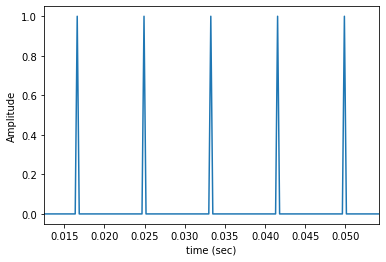

In [ ]:
# Generate periodic excitation signal of F0 frequency
F0 = 120
Fs = 16000
duration = 0.5
T = 1/Fs

tri_pulse_train_120 = triangular_pulse_train_gen(F0, duration, Fs)

plt.plot(time, tri_pulse_train_120)
plt.xlim(1.5/F0,6.5/F0)
plt.xlabel('time (sec)')
plt.ylabel('Amplitude')

In [ ]:
# Output in the case of the three vowels

outputs = {}  # Empty dictionary to store the output
for i in r:
    a1_ = a1.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])
    a2_ = a2.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])
    a3_ = a3.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])
    a4_ = a4.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])
    a5_ = a5.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])
    a6_ = a6.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])

    # Generate output for the vowel i
    outputs[i] = filter_3formant(tri_pulse_train_120, a1_, a2_, a3_, a4_, a5_, a6_)

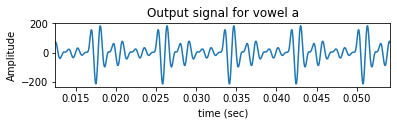

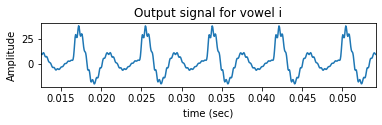

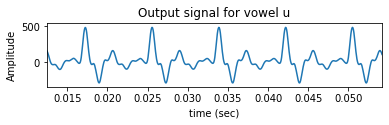

In [ ]:
# Plot the output signals for the three cases
plt_no = 1
for i in outputs:
    plt.subplot(3,1,plt_no)
    plt.plot(time, outputs[i])
    plt.xlim(1.5/F0,6.5/F0)
    plt.xlabel('time (sec)')
    plt.ylabel('Amplitude')
    plt.title('Output signal for vowel '+i)
    plt_no += 1
    plt.show()

In [ ]:
# Write the output sound to output.wav
for i in outputs:
    output_sound = np.int16(outputs[i]/np.max(np.abs(outputs[i]))*32767) # Normalize and convert to int16
    write("output_120_"+str(i)+".wav",Fs,output_sound)                       # Write to output.wav

### Case 1: F0 = 220 Hz

Text(0, 0.5, 'Amplitude')

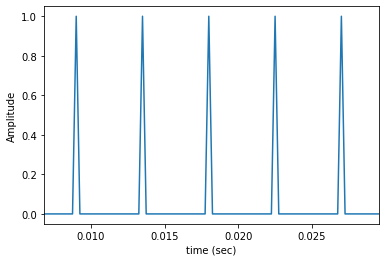

In [ ]:
# Generate periodic excitation signal of F0 frequency
F0 = 220
Fs = 16000
duration = 0.5
T = 1/Fs

tri_pulse_train_220 = triangular_pulse_train_gen(F0, duration, Fs)

plt.plot(time, tri_pulse_train_220)
plt.xlim(1.5/F0,6.5/F0)
plt.xlabel('time (sec)')
plt.ylabel('Amplitude')

In [ ]:
# Output in the case of the three vowels

outputs = {}  # Empty dictionary to store the output
for i in r:
    a1_ = a1.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])
    a2_ = a2.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])
    a3_ = a3.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])
    a4_ = a4.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])
    a5_ = a5.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])
    a6_ = a6.subs([(r_1,r[i][0]),(r_2,r[i][1]),(r_3,r[i][2]),(theta_1,theta[i][0]),(theta_2,theta[i][1]),(theta_3,theta[i][2])])

    # Generate output for the vowel i
    outputs[i] = filter_3formant(tri_pulse_train_220, a1_, a2_, a3_, a4_, a5_, a6_)

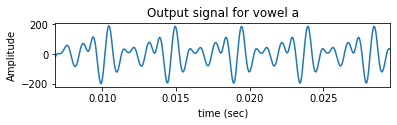

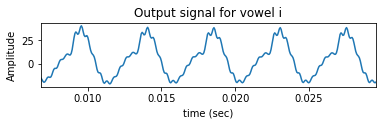

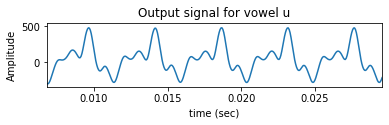

In [ ]:
# Plot the output signals for the three cases
plt_no = 1
for i in outputs:
    plt.subplot(3,1,plt_no)
    plt.plot(time, outputs[i])
    plt.xlim(1.5/F0,6.5/F0)
    plt.xlabel('time (sec)')
    plt.ylabel('Amplitude')
    plt.title('Output signal for vowel '+i)
    plt_no += 1
    plt.show()

In [ ]:
# Write the output sound to output.wav
for i in outputs:
    output_sound = np.int16(outputs[i]/np.max(np.abs(outputs[i]))*32767) # Normalize and convert to int16
    write("output_220_"+str(i)+".wav",Fs,output_sound)                       # Write to output.wav

## Comparing the Audio Quality

/a/ at 120  Hz

In [ ]:
IPython.display.Audio("output_120_a.wav")

/a/ at 220 Hz

In [ ]:
IPython.display.Audio("output_220_a.wav")

/i/ at 120 Hz

In [ ]:
IPython.display.Audio("output_120_i.wav")

/i/ at 220 Hz

In [ ]:
IPython.display.Audio("output_220_i.wav")

/u/ at 120 Hz

In [ ]:
IPython.display.Audio("output_120_u.wav")

/u/ at 220 Hz

In [ ]:
IPython.display.Audio("output_220_u.wav")

### Observation
#### The output generated resemble the vowels very closely. Also, the effect of change in pitch can be clearly heard when F0 was changed from 120 Hz to 220 Hz. Also, the sounds generated are a bit rough